In [1]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
# from transform import *
from transform_audio import *
# from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

data_dir = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wav-processed')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

In [26]:
import random
def subsample_lists(file_list, file_names, p, seed):
    random.seed(seed)
    n_to_include = int(len(file_list) * p)
    random_filter = [True] * n_to_include + [False] * (len(file_list) - n_to_include)
    random.shuffle(random_filter)
    filtered_file_list = [path for path, include in zip(file_list, random_filter) if include]
    filtered_file_names = [name for name, include in zip(file_names, random_filter) if include]
    return filtered_file_list, filtered_file_names

filtered_file_list, filtered_file_names = subsample_lists(file_list, file_names, 0.3, 42)

In [5]:
transform_list(cwt_file, filtered_file_list, filtered_file_names, high_freq=24000, num_scales=50, compress=True)

Computing and exporting coefficients:   0%|          | 0/432 [00:00<?, ?it/s]

# Wavelet representation
Morlet continuous wavelet transform on some example files to start

In [4]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [ ]:
ravdess_df = pd.read_csv(os.path.join(ROOT_DIR, "raw-data", "ravdess", 'full-ravdess.csv'))

In [ ]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal = wavfile.read(file_list[test_file_idx])

wavelet = 'cmor1.5-1.0' # complex morlet: bandwidth = 1.5, center frequency = 1.0
low_freq, high_freq = 80, 8000  # typical range for human speech
num_scales = 100  # can be adjusted for computational efficiency

frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
scales = pywt.frequency2scale(wavelet, frequencies / rate)
coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(coefs),
    aspect='auto',
    cmap='jet',
    extent=[0, len(signal)/rate, low_freq, high_freq]
)
plt.colorbar(label='Magnitude')
# plt.yscale('log') # log scale frequency axis
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('CWT with Morlet Wavelet')
plt.show()

In [ ]:
# generalize above logic into function

def cwt_file(filename, wavelet='cmor1.5-1.0', low_freq=80, high_freq=8000, num_scales=100, visualize=False, title='CWT with Morlet Wavelet'):
    rate, signal = wavfile.read(os.path.join(data_dir, filename)) # currently references global data_dir
    frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
    scales = pywt.frequency2scale(wavelet, frequencies / rate)
    coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.imshow(
            np.abs(coefs),
            aspect='auto',
            cmap='jet',
            extent=[0, len(signal)/rate, low_freq, high_freq]
        )
        plt.colorbar(label='Magnitude')
        # plt.yscale('log')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(title)
        plt.show()

    return coefs, freqs

In [ ]:
# compare male versus female

from functools import reduce

def homogenize(df, *cols):
    return df[reduce(lambda a, b: a & b, (df[col] == df[col][0] for col in cols), np.ones(df.shape[0]))]

hom_df = homogenize(ravdess_df, 'statement', 'emotion', 'intensity')
male_vs_female = hom_df.groupby('sex').first()
male_vs_female

In [ ]:
for sex, filename in zip(male_vs_female.index, male_vs_female['filename']):
    cwt_file(filename, visualize=True, title=f'CWT with Morlet Wavelet: {sex.capitalize()}')

## Frequency band grouping

In [2]:
bands = freq_band_groupings(
    coefs_npz_path='/Users/benrabin/Archive/ravdess-transforms/cwt_coefs_30.npz',
    freqs_npy_path='/Users/benrabin/Archive/ravdess-transforms/cwt_freqs.npy',
    subsample_every=12,
    batch_size=12,
    debug=True
)
bands

[0, 25) ~ [25, 50): presplit
  [0, 12) ~ [12, 25): 0.01367, 0.0
  [25, 37) ~ [37, 50): 0.23203, 0.0
    [25, 31) ~ [31, 37): 0.10239, 0.0
      [25, 28) ~ [28, 31): 0.04783, 0.0
      [31, 34) ~ [34, 37): 0.06452, 0.0
        [31, 32) ~ [32, 34): 0.02836, 0.0
        [34, 35) ~ [35, 37): 0.03642, 0.0
    [37, 43) ~ [43, 50): 0.15383, 0.0
      [37, 40) ~ [40, 43): 0.04812, 0.0
      [43, 46) ~ [46, 50): 0.13174, 0.0
        [43, 44) ~ [44, 46): 0.04310, 0.0
        [46, 48) ~ [48, 50): 0.10086, 0.0
          [46, 47) ~ [47, 48): 0.04212, 0.0
          [48, 49) ~ [49, 50): 0.08897, 0.0


[(0, 25),
 (25, 31),
 (31, 34),
 (34, 37),
 (37, 43),
 (43, 46),
 (46, 48),
 (48, 49),
 (49, 50)]

## Band-based frequency downsampling

In [24]:
freqs = np.load('/Users/benrabin/Archive/ravdess-transforms/morlet/cwt_freqs.npy')
len(freqs)

50

In [19]:
bands_05 = freq_band_groupings(
    '/Users/benrabin/Archive/ravdess-transforms/compressed/cwt_coefs_30.npz',
    '/Users/benrabin/Archive/ravdess-transforms/morlet/cwt_freqs.npy',
    ks_threshold=0.05,
    batch_size=17,
    subsample_every=4,
    presplit_depth=2,
    cache=True,
    debug=True
)

[0, 25) ~ [25, 50): presplit
  [0, 12) ~ [12, 25): presplit
    [0, 6) ~ [6, 12): 0.13805, 0.0
      [0, 3) ~ [3, 6): 0.05261, 0.0
        [0, 1) ~ [1, 3): 0.02335, 0.0
        [3, 4) ~ [4, 6): 0.03727, 0.0
      [6, 9) ~ [9, 12): 0.03905, 0.0
    [12, 18) ~ [18, 25): 0.11644, 0.0
      [12, 15) ~ [15, 18): 0.02255, 0.0
      [18, 21) ~ [21, 25): 0.07066, 0.0
        [18, 19) ~ [19, 21): 0.04147, 0.0
        [21, 23) ~ [23, 25): 0.02487, 0.0
  [25, 37) ~ [37, 50): presplit
    [25, 31) ~ [31, 37): 0.10239, 0.0
      [25, 28) ~ [28, 31): 0.04783, 0.0
      [31, 34) ~ [34, 37): 0.06452, 0.0
        [31, 32) ~ [32, 34): 0.02836, 0.0
        [34, 35) ~ [35, 37): 0.03642, 0.0
    [37, 43) ~ [43, 50): 0.15383, 0.0
      [37, 40) ~ [40, 43): 0.04812, 0.0
      [43, 46) ~ [46, 50): 0.13174, 0.0
        [43, 44) ~ [44, 46): 0.04310, 0.0
        [46, 48) ~ [48, 50): 0.10086, 0.0
          [46, 47) ~ [47, 48): 0.04212, 0.0
          [48, 49) ~ [49, 50): 0.08897, 0.0


In [20]:
bands_0375 = freq_band_groupings(
    '/Users/benrabin/Archive/ravdess-transforms/compressed/cwt_coefs_30.npz',
    '/Users/benrabin/Archive/ravdess-transforms/morlet/cwt_freqs.npy',
    ks_threshold=0.0375,
    subsample_every=4,
    presplit_depth=2,
    cache=True,
    debug=False
)

In [21]:
bands_025 = freq_band_groupings(
    '/Users/benrabin/Archive/ravdess-transforms/compressed/cwt_coefs_30.npz',
    '/Users/benrabin/Archive/ravdess-transforms/morlet/cwt_freqs.npy',
    ks_threshold=0.025,
    subsample_every=4,
    presplit_depth=2,
    cache=True,
    debug=False
)

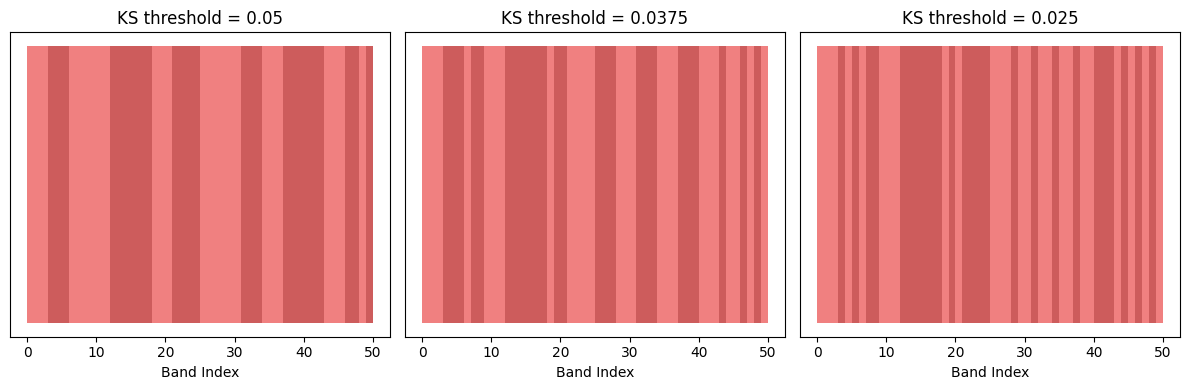

In [22]:
colors = ['lightcoral', 'indianred']
def plot_bands(ax, bands, title):
    for i, (start, end) in enumerate(bands):
        color = colors[i % 2]
        ax.broken_barh([(start, end - start)], (0, 1), facecolors=color)
    ax.set_xlabel('Band Index')
    ax.set_yticks([])
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_bands(axs[0], bands_05, 'KS threshold = 0.05')
plot_bands(axs[1], bands_0375, 'KS threshold = 0.0375')
plot_bands(axs[2], bands_025, 'KS threshold = 0.025')
plt.tight_layout()
plt.show()

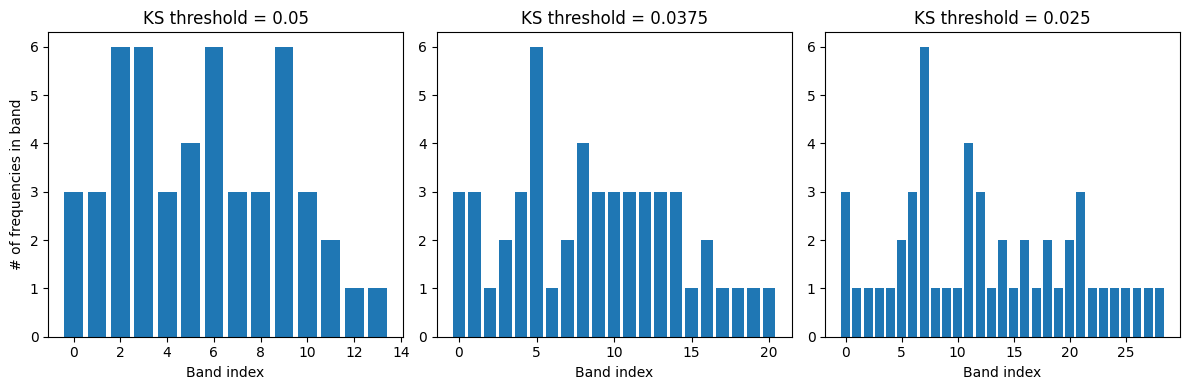

In [23]:
bands_to_widths = lambda bands: [band[1] - band[0] for band in bands]
widths_05, widths_0375, widths_025 = map(bands_to_widths, (bands_05, bands_0375, bands_025))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].bar(np.arange(len(bands_05)), widths_05)
axs[0].set_title('KS threshold = 0.05')
axs[1].bar(np.arange(len(bands_0375)), widths_0375)
axs[1].set_title('KS threshold = 0.0375')
axs[2].bar(np.arange(len(bands_025)), widths_025)
axs[2].set_title('KS threshold = 0.025')

axs[0].set_ylabel('# of frequencies in band')
for ax in axs:
    ax.set_xlabel('Band index')
plt.tight_layout()
plt.show()

In [18]:
def cap_array(arr, cap):
    capped_arr = np.array(arr)
    capped_arr[capped_arr > cap] = cap
    return capped_arr

In [26]:
cap_array(widths_0375, 2).sum()

np.int64(35)